# **Music Theme Recognition**

Chuang Caleb
20204134


## **Package Imports**


In [136]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import VarianceThreshold

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids

from skmultilearn.adapt import MLkNN
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, hamming_loss, f1_score

from manual_feature_preselection import mtr_load_feature_set

## **Choosing Parameters**


Load manually preselected/shortlisted features

In [137]:
preselected_feature_list = mtr_load_feature_set.load_feature_set()


Successfully written manually preselected features to manual_feature_preselection/manually_preselected_features.txt



In [138]:
target_label = 'risk'
feature_start = 'Vertical_Unisons'
feature_end = 'Minor_Major_Triad_Ratio'

k_value = 3

threshold_val = 0

rand_state = 15


## **Importing Dataset**


#### Features


In [139]:
# Access song_theme_feature_database
song_theme_feature_database_path = '../data/features/song_theme_feature_database.csv'
raw_feature_df = pd.read_csv(song_theme_feature_database_path)

#### Labels


In [140]:
# Access song_theme_labels_database
song_theme_label_database_path = '../data/song_theme_label_database.xlsx'
raw_label_df = pd.read_excel(song_theme_label_database_path)


## **Prepare datasets**


### Manual Selection

Select the features for this iteration


In [141]:
# man_feature_df = raw_feature_df.loc[:, feature_start:feature_end]
man_feature_df = raw_feature_df[preselected_feature_list]


Select the labels for this iteration


In [142]:
# Filter for only recognized samples in labels_df
main_label_df = raw_label_df[raw_label_df.recognizable == 1]

# Filter out unused labels and metadata
main_label_df.drop(
    columns=main_label_df.columns[19:], axis=1, inplace=True)  # unused labels
main_label_df.drop(
    columns=main_label_df.columns[0:4], axis=1, inplace=True)  # metadata

# label_df = main_label_df
# label_df = main_label_df[target_label]
label_df = main_label_df[[target_label]]


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Feature Selection


Filter out features with zero variance


In [143]:
constant_filter = VarianceThreshold(threshold=threshold_val)
constant_filter.fit(man_feature_df)
constant_columns = [column for column in man_feature_df.columns
                    if column not in
                    man_feature_df.columns[constant_filter.get_support()]]
var_feature_np = constant_filter.transform(man_feature_df)
# x_test = constant_filter.transform(label_df)
# for column in constant_columns:
#     print("Removed ", column)
print(f"Started with {man_feature_df.shape[1]} features.")
print(
    f"Removed {len(constant_columns)} feature(s) that having variance of {threshold_val}.")
print(f"There are {(var_feature_np.shape[1])} features left.")

feature_names = [
    x for x in man_feature_df.columns if not x in constant_columns]


Started with 199 features.
Removed 1 feature(s) that having variance of 0.
There are 198 features left.


Filter out features with low importance


## **Transforming Data**


In [144]:
# from numpy import ravel

# feature_np = feature_df.to_numpy()
# label_np = label_df.to_numpy()
# # feature_np = feature_df
# # label_np = label_df

# feature_np = feature_df.to_numpy()
feature_np = var_feature_np
label_np = label_df.to_numpy().astype(int)

ids_df = raw_feature_df['sample']


### Splitting dataset


In [145]:
(x_train, x_test, y_train, y_test, ids_train, ids_test) = train_test_split(
    feature_np, label_np, ids_df, test_size=0.2, random_state=rand_state)


In [146]:
var_feature_np.shape

(130, 198)

### Sampling Data

For balanced dataset


In [147]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0,shrinkage= 0.4)
# X_resampled, y_resampled = ros.fit_resample(x_train, y_train)

# from collections import Counter
# print(sorted(Counter(y_resampled).items()))


In [148]:
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_resampled, y_resampled = rus.fit_resample(x_train, y_train)

# from collections import Counter
# print(sorted(Counter(y_resampled).items()))


In [149]:
# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=888)
# x_train, y_train = smote.fit_resample(x_train, y_train)

# y_train.value_counts()


## **Working Model**


In [150]:
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# from sklearn.pipeline import make_pipeline
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import cross_validate


# model_with_selection = make_pipeline(
#     SelectKBest(score_func=f_classif, k=2),
#     RandomForestClassifier(n_jobs=2),
# )

# label_np = ravel(label_np)

# cv_results_with_selection = cross_validate(
#     model_with_selection, feature_np, label_np, return_estimator=True)
# cv_results_with_selection = pd.DataFrame(cv_results_with_selection)

# cv_results_with_selection


In [151]:
from sklearn.tree import DecisionTreeClassifier

parameters = {'k': range(3, 5), 's': [0.5, 0.7, 1.0]}
score = 'f1_macro'
# from imblearn.ensemble import BalancedRandomForestClassifier

# classifier = GridSearchCV(MLkNN(), parameters, scoring=score)
# classifier = MLkNN()

classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=rand_state) # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decision%20tree%20classifier#sklearn.tree.DecisionTreeClassifier

# classifier = BalancedRandomForestClassifier(n_estimators=500, random_state=rand_state)
classifier.fit(x_train, y_train)

# print(classifier.best_params_, classifier.best_score_)
# classifier.fit(X_resampled, y_resampled)


DecisionTreeClassifier(max_leaf_nodes=10, random_state=15)

[Text(0.5, 0.9, 'Melodic_Perfect_Fourths <= 0.062\ngini = 0.273\nsamples = 104\nvalue = [87, 17]\nclass = null'),
 Text(0.3076923076923077, 0.7, 'Mean_Tempo <= 119.75\n0.5\n26\n[13, 13]\nnull'),
 Text(0.15384615384615385, 0.5, 'Minimum_Note_Duration <= 0.001\n0.26\n13\n[11, 2]\nnull'),
 Text(0.07692307692307693, 0.3, '0.0\n2\n[0, 2]\nrisk'),
 Text(0.23076923076923078, 0.3, '0.0\n11\n[11, 0]\nnull'),
 Text(0.46153846153846156, 0.5, 'Perfect_Vertical_Intervals <= 0.418\n0.26\n13\n[2, 11]\nrisk'),
 Text(0.38461538461538464, 0.3, '0.0\n2\n[2, 0]\nnull'),
 Text(0.5384615384615384, 0.3, '0.0\n11\n[0, 11]\nrisk'),
 Text(0.6923076923076923, 0.7, 'Pitch_Class_Kurtosis <= 4.55\n0.097\n78\n[74, 4]\nnull'),
 Text(0.6153846153846154, 0.5, '0.0\n2\n[0, 2]\nrisk'),
 Text(0.7692307692307693, 0.5, 'Stepwise_Motion <= 0.042\n0.051\n76\n[74, 2]\nnull'),
 Text(0.6923076923076923, 0.3, '0.0\n1\n[0, 1]\nrisk'),
 Text(0.8461538461538461, 0.3, 'Prevalence_of_Most_Common_Pitch <= 0.048\n0.026\n75\n[74, 1]\nnul

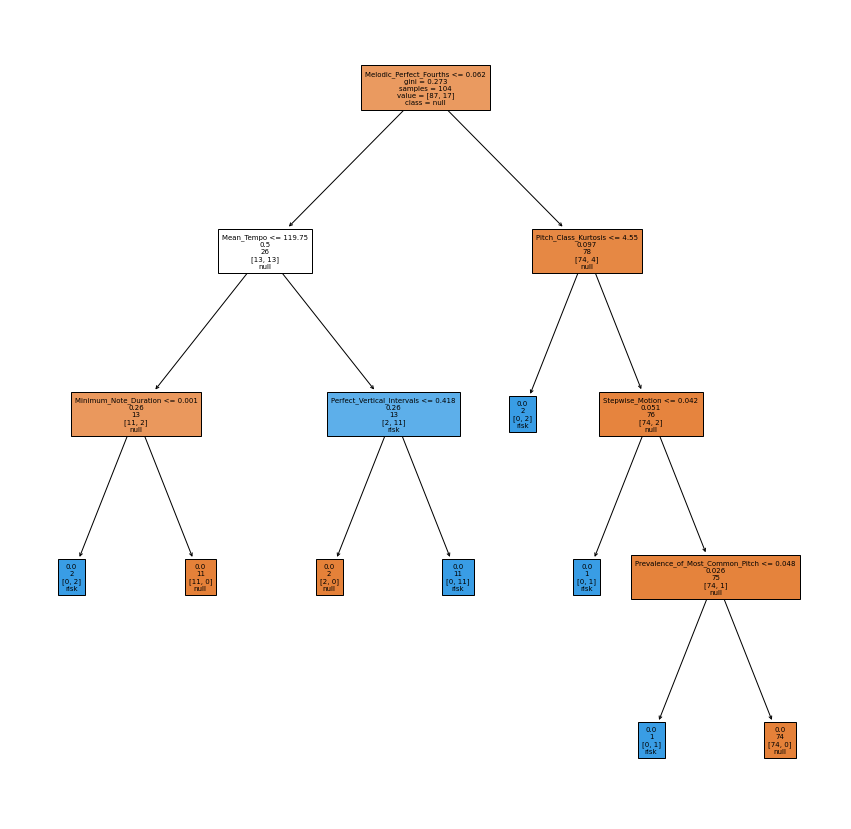

In [152]:
from sklearn import tree
import matplotlib.pyplot as plt

# print(export_text(classifier, feature_names=final_columns))

plt.figure(figsize=(15, 15))
tree.plot_tree(classifier, feature_names=feature_names, class_names=[
               'null', target_label], label='root', filled=True, fontsize=7)


## **Evaluation**


### Prediction


In [153]:
predictions = classifier.predict(x_test)


### Metrics


In [154]:
# scores = cross_val_score(classifier, x_test, y_test, cv=3, scoring='accuracy')

print('Accuracy: ' + str(accuracy_score(y_test, predictions)))
print('Haming Loss: ' + str(hamming_loss(y_test, predictions)))
print('F1-score: ' + str(f1_score(y_test, predictions)))


Accuracy: 0.7307692307692307
Haming Loss: 0.2692307692307692
F1-score: 0.2222222222222222


Display results


In [155]:
predictions_df = pd.DataFrame(predictions, columns=label_df.columns)
y_test_df = pd.DataFrame(predictions, columns=label_df.columns)

results = pd.DataFrame(
    # {'sample': ids_test, 'y_true': flat_y_true, 'y_pred': flat_predictions})
    # {'sample': ids_test, 'y_true': y_test, 'y_pred': predictions})
    {'sample': ids_test.reset_index(drop=True), 'y_true': y_test_df[target_label], 'y_pred': predictions_df[target_label]})

results = results.sort_index()

results


,sample,y_true,y_pred
0,court.mid,1,1
1,adele-rolling_in_the_deep_bitmidi.mid,0,0
2,coldplay-a_sky_full_of_stars_bitmidi.mid,0,0
3,braveheart_bitmidi.mid,0,0
4,Romantic_Flight Finale.mid,0,0
5,I Just Can't Wait To Be King.BSO The Lion King...,0,0
6,Disney Themes_The Bear Necessities_midiworld.mid,0,0
7,Billy Joel - Uptown Girl_bitmidi.mid,0,0
8,allstar_bitmidi.mid,0,0
9,Happy-Birthday-2_bitmidi.mid,1,1
